In [ ]:
import torch
import matplotlib.pyplot as plt


class ParameterEstimator:
    def __init__(self, model_func, param_init, optimizer_cls=torch.optim.Adam, lr=0.01, loss_fn=None):
        """
        Generalized parameter estimation using PyTorch.
        
        Args:
            model_func: Callable model f(x, *params)
            param_init: List or dict of initial parameter guesses
            optimizer_cls: PyTorch optimizer class (default Adam)
            lr: Learning rate
            loss_fn: Custom loss function (default MSE)
        """
        self.model_func = model_func
        self.params = self._init_params(param_init)
        self.optimizer = optimizer_cls(self.params.values(), lr=lr)
        self.loss_fn = loss_fn if loss_fn else torch.nn.MSELoss()

    def _init_params(self, param_init):
        if isinstance(param_init, dict):
            return {name: torch.tensor(val, requires_grad=True, dtype=torch.float32)
                    for name, val in param_init.items()}
        elif isinstance(param_init, (list, tuple)):
            return {f"p{i}": torch.tensor(val, requires_grad=True, dtype=torch.float32)
                    for i, val in enumerate(param_init)}
        else:
            raise ValueError("param_init must be a list or dict")

    def fit(self, x_data, y_data, epochs=1000, verbose=True):
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            y_pred = self.model_func(x_data, **self.params)
            loss = self.loss_fn(y_pred, y_data)
            loss.backward()
            self.optimizer.step()

            if verbose and epoch % (epochs // 10) == 0:
                loss_val = loss.item()
                param_str = ", ".join(f"{k}={v.item():.4f}" for k, v in self.params.items())
                print(f"Epoch {epoch:4d} | Loss={loss_val:.6f} | {param_str}")

        return {k: v.item() for k, v in self.params.items()}


In [6]:
# ---------- SINGLE-PARAMETER KINETIC MODELS ----------

def zero_order_single(t, k, C0=1.0):
    """Zero-order (C0 known)"""
    return C0 - k * t

def first_order_single(t, k, C0=1.0):
    """First-order (C0 known)"""
    return C0 * torch.exp(-k * t)

def second_order_single(t, k, C0=1.0):
    """Second-order (C0 known)"""
    return 1 / (1/C0 + k * t)

def arrhenius_single(T, Ea, A=1e5):
    """Arrhenius (A known)"""
    R = 8.314
    return A * torch.exp(-Ea / (R * T))

def pseudo_first_order_single(t, k1, qe=1.0):
    """Pseudo-first-order adsorption (qe known)"""
    return qe * (1 - torch.exp(-k1 * t))

def newton_drying_single(t, k, M0=1.0, Me=0.1):
    """Newton drying model (M0, Me known)"""
    return Me + (M0 - Me) * torch.exp(-k * t)


Epoch    0 | Loss=0.345631 | k=0.1500, C0=0.1500
Epoch   50 | Loss=0.001274 | k=0.3140, C0=1.0735
Epoch  100 | Loss=0.000745 | k=0.2862, C0=1.0171
Epoch  150 | Loss=0.000738 | k=0.2899, C0=1.0222
Epoch  200 | Loss=0.000738 | k=0.2900, C0=1.0221
Epoch  250 | Loss=0.000738 | k=0.2900, C0=1.0220
Epoch  300 | Loss=0.000738 | k=0.2900, C0=1.0220
Epoch  350 | Loss=0.000738 | k=0.2900, C0=1.0220
Epoch  400 | Loss=0.000738 | k=0.2900, C0=1.0220
Epoch  450 | Loss=0.000738 | k=0.2900, C0=1.0220
Estimated Parameters: {'k': 0.2899823784828186, 'C0': 1.0220227241516113}


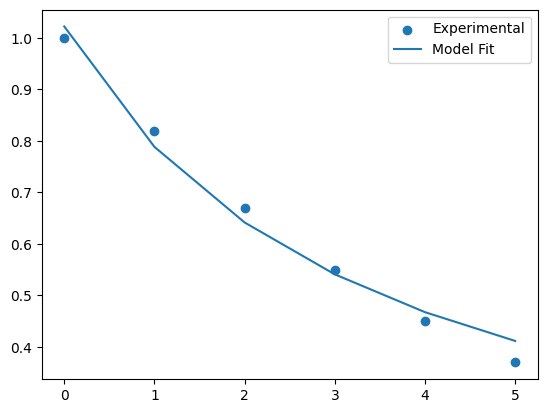

In [8]:

# Experimental data
t_data = torch.tensor([0, 1, 2, 3, 4, 5])
C_data = torch.tensor([1.0, 0.82, 0.67, 0.55, 0.45, 0.37])



# # model
# def first_order_model(t, k):
#     return torch.exp(-k * t)

model = second_order_single
parameter = {"k": 0.2,"C0":0.1}


# Create estimator
estimator = ParameterEstimator(
    model_func=model,
    param_init= parameter,
    lr=0.05
)

# Fit
params = estimator.fit(t_data, C_data, epochs=500)
print("Estimated Parameters:", params)


# Plot
with torch.no_grad():
    plt.scatter(t_data, C_data, label="Experimental")
    plt.plot(t_data, model(t_data, **{k: torch.tensor(v) for k, v in params.items()}), label="Model Fit")
    plt.legend()
    plt.show()